In [1]:
import logging
import yaml

import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import asyncio

# import palpy

from lsst.ts import salobj

from lsst.ts.standardscripts.auxtel.attcs import ATTCS

from lsst.ts.idl.enums import ATPtg

%matplotlib inline

In [2]:
from astropy.utils import iers
iers.conf.auto_download = False

In [3]:
d = salobj.Domain()

In [4]:
atmcs = salobj.Remote(d, "ATMCS")
atptg = salobj.Remote(d, "ATPtg")
ataos = salobj.Remote(d, "ATAOS")
atpne = salobj.Remote(d, "ATPneumatics")
athex = salobj.Remote(d, "ATHexapod")
atdome = salobj.Remote(d, "ATDome", index=1)
atdomtraj = salobj.Remote(d, "ATDomeTrajectory")

In [5]:
await asyncio.gather(atmcs.start_task, 
                     atptg.start_task,
                     ataos.start_task,
                     atpne.start_task,
                     athex.start_task,
                     atdome.start_task,
                     atdomtraj.start_task)

AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 10 messages


[None, None, None, None, None, None, None]

# ATMCS

In [12]:
await asyncio.sleep(5.)
print("Done")
await salobj.set_summary_state(atmcs, salobj.State.ENABLED)

RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 40 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteTelemetry(ATMCS, 0, azEl_mountMotorEncoders) falling behind; read 14 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 30 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 39 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 39 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 30 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 14 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 39 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 40 messages
Re

Done


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

# ATPtg

In [11]:
await asyncio.sleep(5.)
print("Done")
await atptg.tel_timeAndDate.next(flush=True, timeout=5)
await salobj.set_summary_state(atptg, salobj.State.ENABLED)

RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 72 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 73 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 72 messages
RemoteEvent(ATMCS, 0, heartbeat) falling behind; read 72 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 72 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 72 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 72 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 72 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 73 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 55 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 72 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 72 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 73 messages
RemoteEvent(ATAOS, 0, m1Corr

Done


[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await atptg.cmd_azElTarget.set_start(azDegs=243., elDegs=80.)

In [13]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [14]:
ra = Angle("00:43:35.37090", unit=u.hour)
dec = Angle("-17:59:11.7827 ", unit=u.deg)
target_name="Beta Cet"
radec = ICRS(ra, dec)

In [ ]:
await atmcs.cmd_stopTracking.start()

In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [15]:
# Figure out what is the rotPA that sets nasmith rotator close to zero.
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
print(curr_time_atptg)
coord_frame_altaz = AltAz(location=location, obstime=curr_time_atptg)
alt_az = radec.transform_to(coord_frame_altaz)

print("slew...")
# await atmcs.cmd_startTracking.start(timeout=10)
await atptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    targetInstance=ATPtg.TargetInstances.CURRENT,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=radec.ra.hour,
    declination=radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=180.-alt_az.alt.deg,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 70 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 24 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 30 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 30 messages
falling behind; queue contains 69 elements
falling behind; queue contains 68 elements
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 30 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 30 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 23 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 30 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 23 messages
R

58738.26120898681
slew...


In [ ]:
await atptg.cmd_stopTracking.start(timeout=10)

In [ ]:
ss = await atdome.evt_summaryState.next(flush=False, timeout=5)

In [ ]:
print(salobj.State(ss.summaryState))

In [ ]:
ss = await atdomtraj.evt_summaryState.next(flush=False, timeout=5)

In [ ]:
print(salobj.State(ss.summaryState))

In [ ]:
await atdomtraj.cmd_enable.start()

In [16]:
async def wait_center():
    while True:
        opt = input("Center telescope and choose action (press ?<enter>, for list of actions): ")
        
        if opt == 'n':
            print("Next point in the grid...")
            return 1
        elif opt == 'p':
            print("Previous point in the grid...")
            return -1
        elif opt == 't':
            print("Stopping test...")
            return 0
        elif opt == '?':
            print("""Options are:
            n - Go to next point in the grid.
            p - Go to previous point in the grid.
            t - Terminate test.
            """)
        else:
            print("Next point in the grid...")
            return 1

In [17]:
dalt_grid = np.arange(-0.25, +0.255, 0.05)+0.45
daz_grid = np.arange(-0.25, +0.255, 0.05)-0.2

In [ ]:
await atptg.cmd_offsetAzEl.set_start(el=0.45*60.*60., 
                                     az=-0.2*60*60, 
                                         num=0)

In [18]:
grid_alt = np.zeros(len(dalt_grid)*len(daz_grid))
grid_az = np.zeros(len(dalt_grid)*len(daz_grid))

for i in range(len(daz_grid)):
    grid_alt[i*len(dalt_grid):(i+1)*len(dalt_grid)] += dalt_grid[::(-1)**i]
    grid_az[i*len(dalt_grid):(i+1)*len(dalt_grid)] += daz_grid[i]

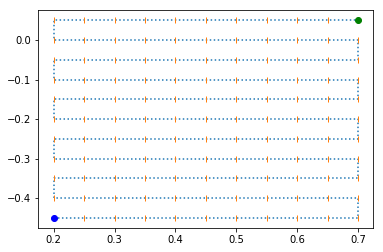

In [19]:
plt.plot(grid_alt, grid_az, ':')
plt.plot(grid_alt, grid_az, '|')
plt.plot(grid_alt[0], grid_az[0], 'bo')
plt.plot(grid_alt[-1], grid_az[-1], 'go')

In [20]:
start_from=56

In [21]:
print(f"Grid has {len(grid_alt)} pointings...")
print(f"Starting from {start_from}")

i = start_from
stop_at = 0

while i < len(grid_alt):
    
    print(f"GRID[{i}]: {grid_alt[i]} x {grid_az[i]}")

    await atptg.cmd_offsetAzEl.set_start(el=grid_alt[i]*60.*60., 
                                         az=grid_az[i]*60*60, 
                                         num=0)
    
    ret_val = await wait_center()

    if ret_val == 0:
        break
        
    i += ret_val
    
    if i < 0:
        print(f"Unwrapping index! (i={i})")
        i = 0

RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
AckCmdReader(ATMCS, 0, ackcmd) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages


Grid has 121 pointings...
Starting from 56
GRID[56]: 0.6499999999999999 x -0.20000000000000007


RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTimesToLimits) falling behind; read 30 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 100 messages
RemoteEvent(ATPtg, 0, weatherDataApplied) falling behind; read 15 messages
RemoteEvent(ATPneumatics, 0, heartbeat) falling behind; read 100 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 47 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 47 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 36 messages


Next point in the grid...
GRID[57]: 0.5999999999999999 x -0.20000000000000007


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 42 elements


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[58]: 0.5499999999999999 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 10 elements


Next point in the grid...
GRID[59]: 0.49999999999999994 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 11 elements


Next point in the grid...
GRID[60]: 0.44999999999999996 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 79 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 19 messages


Next point in the grid...
GRID[61]: 0.39999999999999997 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 88 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 18 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 17 messages
RemoteEvent(ATDome, 1, heartbeat) falling behind; read 18 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 17 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 13 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 18 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 89 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 18 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behin

Next point in the grid...
GRID[62]: 0.35 x -0.20000000000000007


falling behind; queue contains 38 elements


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATDome, 1, position) falling behind; read 33 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 14 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 33 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 33 messages


Next point in the grid...
GRID[63]: 0.3 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 58 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 14 messages


Next point in the grid...
GRID[64]: 0.25 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 77 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 19 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[65]: 0.2 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 75 messages


Next point in the grid...
GRID[66]: 0.2 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 55 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 14 messages


Next point in the grid...
GRID[67]: 0.25 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 63 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[68]: 0.3 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 85 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 21 messages


Next point in the grid...
GRID[69]: 0.35 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 58 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[70]: 0.39999999999999997 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 51 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 12 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 13 messages


Next point in the grid...
GRID[71]: 0.44999999999999996 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 14 messages
falling behind; queue contains 13 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 28 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 10 messages


Next point in the grid...
GRID[72]: 0.49999999999999994 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 83 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 20 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


Next point in the grid...
GRID[73]: 0.5499999999999999 x -0.15000000000000008


Center telescope and choose action (press ?<enter>, for list of actions):  p


RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 24 messages


Previous point in the grid...
GRID[72]: 0.49999999999999994 x -0.15000000000000008


RemoteTelemetry(ATDome, 1, position) falling behind; read 100 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 24 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 18 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 25 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 18 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 25 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 25 messages
AckCmdReader(ATPneumatics, 0, ackcmd) falling behind; read 54 messages
falling behind; queue contains 53 elements
falling behind; queue contains 52 elements


Center telescope and choose action (press ?<enter>, for list of actions):  t


Stopping test...


In [33]:
await atptg.cmd_offsetAzEl.set_start(el=0., 
                                     az=-30, 
                                         num=1)

RemoteEvent(ATDome, 1, heartbeat) falling behind; read 10 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 10 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 10 messages
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
falling behind; queue contains 21 elements
RemoteTelemetry(ATDome, 1, position) falling behind; read 48 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, mount_Nasmyth_Encoders) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, mount_AzEl_Encoders) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, measuredTorque) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, measuredMotorVelocity) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, azEl_mountMotorEncoders) falling behind; read 10 messages
falling behind; queue contains 99 elements
falling behind; queue 

falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements


In [26]:
await atptg.cmd_offsetAzEl.set_start(el=10., 
                                     az=0, 
                                         num=1)

RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 57 messages
RemoteTelemetry(ATDome, 1, position) falling behind; read 55 messages
falling behind; queue contains 26 elements
falling behind; queue contains 99 elements
falling behind; queue contains 98 elements
falling behind; queue contains 97 elements
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 56 messages


In [ ]:
60-61